In [1]:
!git clone https://github.com/TharunSivamani/ERA-V1.git
%cd ERA-V1/Session 10
!git pull

Cloning into 'ERA-V1'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 268 (delta 5), reused 14 (delta 3), pack-reused 251
Receiving objects: 100% (268/268), 3.84 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/ERA-V1/Session 10
Already up to date.


In [2]:
!pip install -r requirements.txt

# Importing Libraries

In [3]:
import torch
import torch.optim as optim
from torchsummary import summary
import torch.nn as nn
from torch_lr_finder import LRFinder
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from utils import get_device, visualize_data
from custom_resnet import Model
from backprop import train , test , plot_graphs , get_misclassified_images , accuracy_classes , show_misclassified_images

In [5]:
torch.manual_seed(1)

# Dataset

In [6]:
from dataset import CIFAR10

In [7]:
data = CIFAR10()

100%|██████████| 170498071/170498071 [00:05<00:00, 28537905.97it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [8]:
train_loader , test_loader = data.get_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
device = get_device()

Device :  cuda


In [10]:
classes = [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]

# Visualising

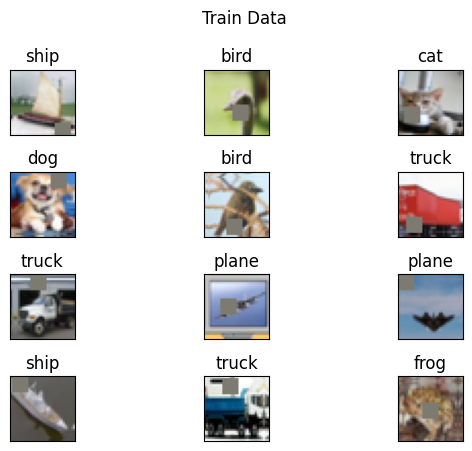

In [11]:
visualize_data(train_loader, 12, "Train Data", classes)

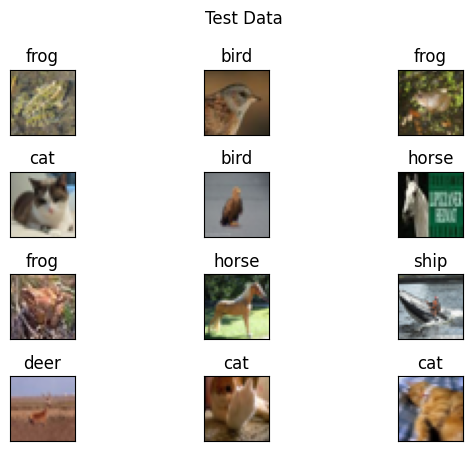

In [12]:
visualize_data(test_loader, 12, "Test Data", classes)

# Model Training

In [13]:
model = Model(dropout=0.05).to(device)
summary(model, input_size=( 3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
         ConvLayer-5           [-1, 64, 32, 32]               0
 Make_Custom_Layer-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,728
         MaxPool2d-8          [-1, 128, 16, 16]               0
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
          Dropout-11          [-1, 128, 16, 16]               0
        ConvLayer-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

# One Cycle LR Policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.57E-02


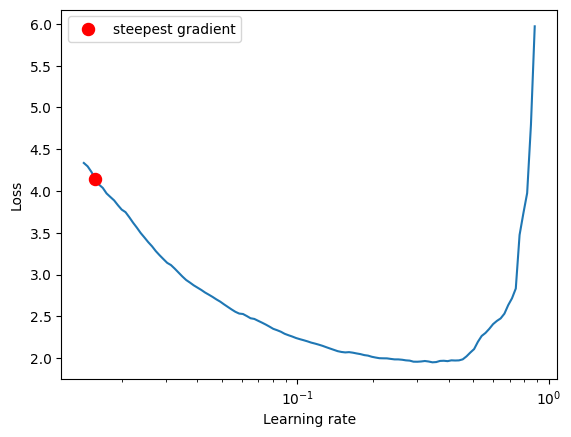

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
_ , best_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [15]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
EPOCHS = 24
scheduler = OneCycleLR(
        optimizer,
        max_lr = best_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)

Epoch 1


Train: Loss=1.0852 Batch_id=97 Accuracy=50.04: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0024, Accuracy: 5787/10000 (57.87%)

Epoch 2


Train: Loss=0.8419 Batch_id=97 Accuracy=68.43: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.0020, Accuracy: 6744/10000 (67.44%)

Epoch 3


Train: Loss=0.8217 Batch_id=97 Accuracy=72.85: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]


Test set: Average loss: 0.0020, Accuracy: 6993/10000 (69.93%)

Epoch 4


Train: Loss=0.4805 Batch_id=97 Accuracy=76.72: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0016, Accuracy: 7381/10000 (73.81%)

Epoch 5


Train: Loss=0.6502 Batch_id=97 Accuracy=78.39: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0014, Accuracy: 7637/10000 (76.37%)

Epoch 6


Train: Loss=0.5519 Batch_id=97 Accuracy=80.86: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0014, Accuracy: 7595/10000 (75.95%)

Epoch 7


Train: Loss=0.5317 Batch_id=97 Accuracy=82.94: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0010, Accuracy: 8334/10000 (83.34%)

Epoch 8


Train: Loss=0.3795 Batch_id=97 Accuracy=83.80: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]


Test set: Average loss: 0.0010, Accuracy: 8321/10000 (83.21%)

Epoch 9


Train: Loss=0.4223 Batch_id=97 Accuracy=84.84: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0011, Accuracy: 8130/10000 (81.30%)

Epoch 10


Train: Loss=0.4683 Batch_id=97 Accuracy=85.50: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.0012, Accuracy: 7933/10000 (79.33%)

Epoch 11


Train: Loss=0.3475 Batch_id=97 Accuracy=86.13: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8503/10000 (85.03%)

Epoch 12


Train: Loss=0.3683 Batch_id=97 Accuracy=86.82: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0009, Accuracy: 8459/10000 (84.59%)

Epoch 13


Train: Loss=0.3503 Batch_id=97 Accuracy=86.92: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0011, Accuracy: 8213/10000 (82.13%)

Epoch 14


Train: Loss=0.3494 Batch_id=97 Accuracy=87.89: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0008, Accuracy: 8590/10000 (85.90%)

Epoch 15


Train: Loss=0.3446 Batch_id=97 Accuracy=88.38: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0008, Accuracy: 8655/10000 (86.55%)

Epoch 16


Train: Loss=0.3316 Batch_id=97 Accuracy=88.76: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0007, Accuracy: 8748/10000 (87.48%)

Epoch 17


Train: Loss=0.3663 Batch_id=97 Accuracy=89.43: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0007, Accuracy: 8785/10000 (87.85%)

Epoch 18


Train: Loss=0.2928 Batch_id=97 Accuracy=90.28: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0007, Accuracy: 8875/10000 (88.75%)

Epoch 19


Train: Loss=0.2395 Batch_id=97 Accuracy=91.00: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0007, Accuracy: 8874/10000 (88.74%)

Epoch 20


Train: Loss=0.2269 Batch_id=97 Accuracy=91.59: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]


Test set: Average loss: 0.0006, Accuracy: 8955/10000 (89.55%)

Epoch 21


Train: Loss=0.2636 Batch_id=97 Accuracy=92.89: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]


Test set: Average loss: 0.0006, Accuracy: 9087/10000 (90.87%)

Epoch 22


Train: Loss=0.1839 Batch_id=97 Accuracy=94.06: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0005, Accuracy: 9185/10000 (91.85%)

Epoch 23


Train: Loss=0.1249 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0005, Accuracy: 9266/10000 (92.66%)

Epoch 24


Train: Loss=0.1325 Batch_id=97 Accuracy=96.53: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]


Test set: Average loss: 0.0004, Accuracy: 9310/10000 (93.10%)



# Model Visualisation

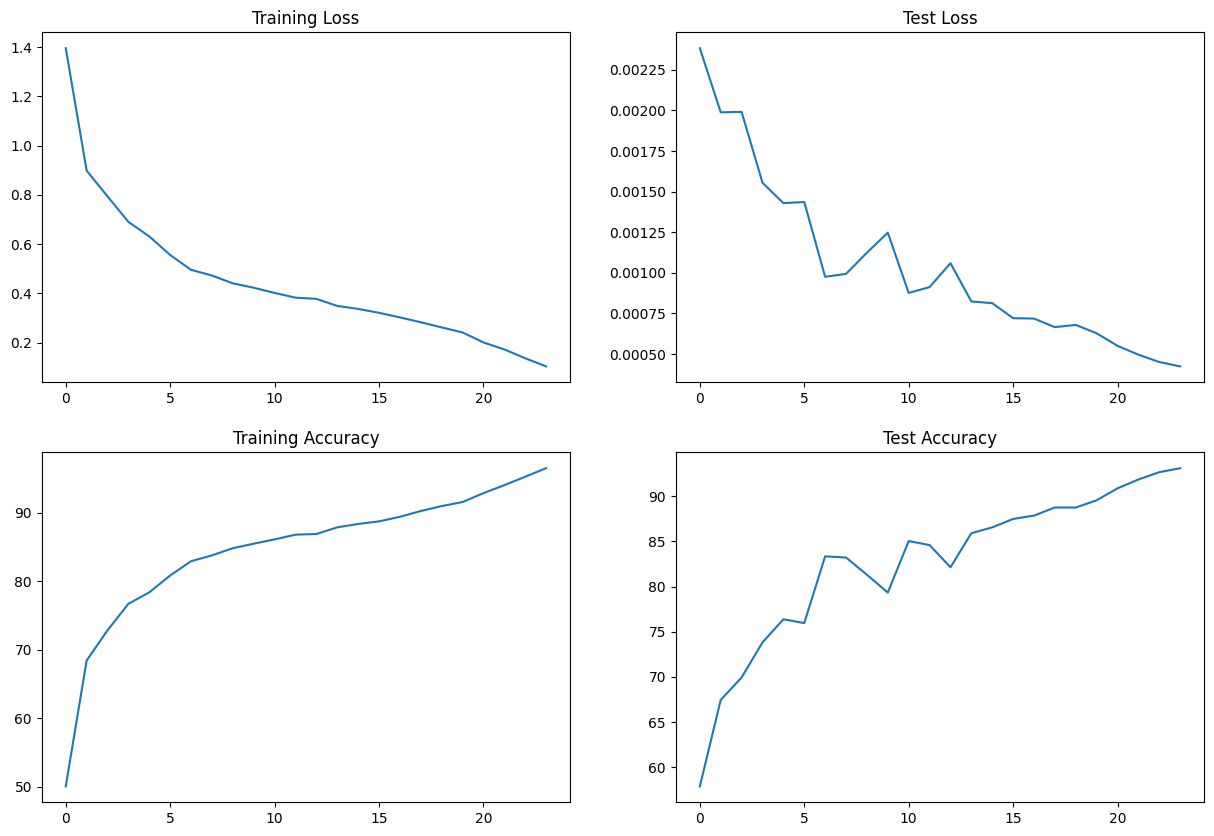

In [16]:
plot_graphs(train_losses , train_acc , test_losses , test_acc)

# Mis-Classified Images

In [17]:
misclassified_images, predictions, labels = get_misclassified_images(model, test_loader, device)

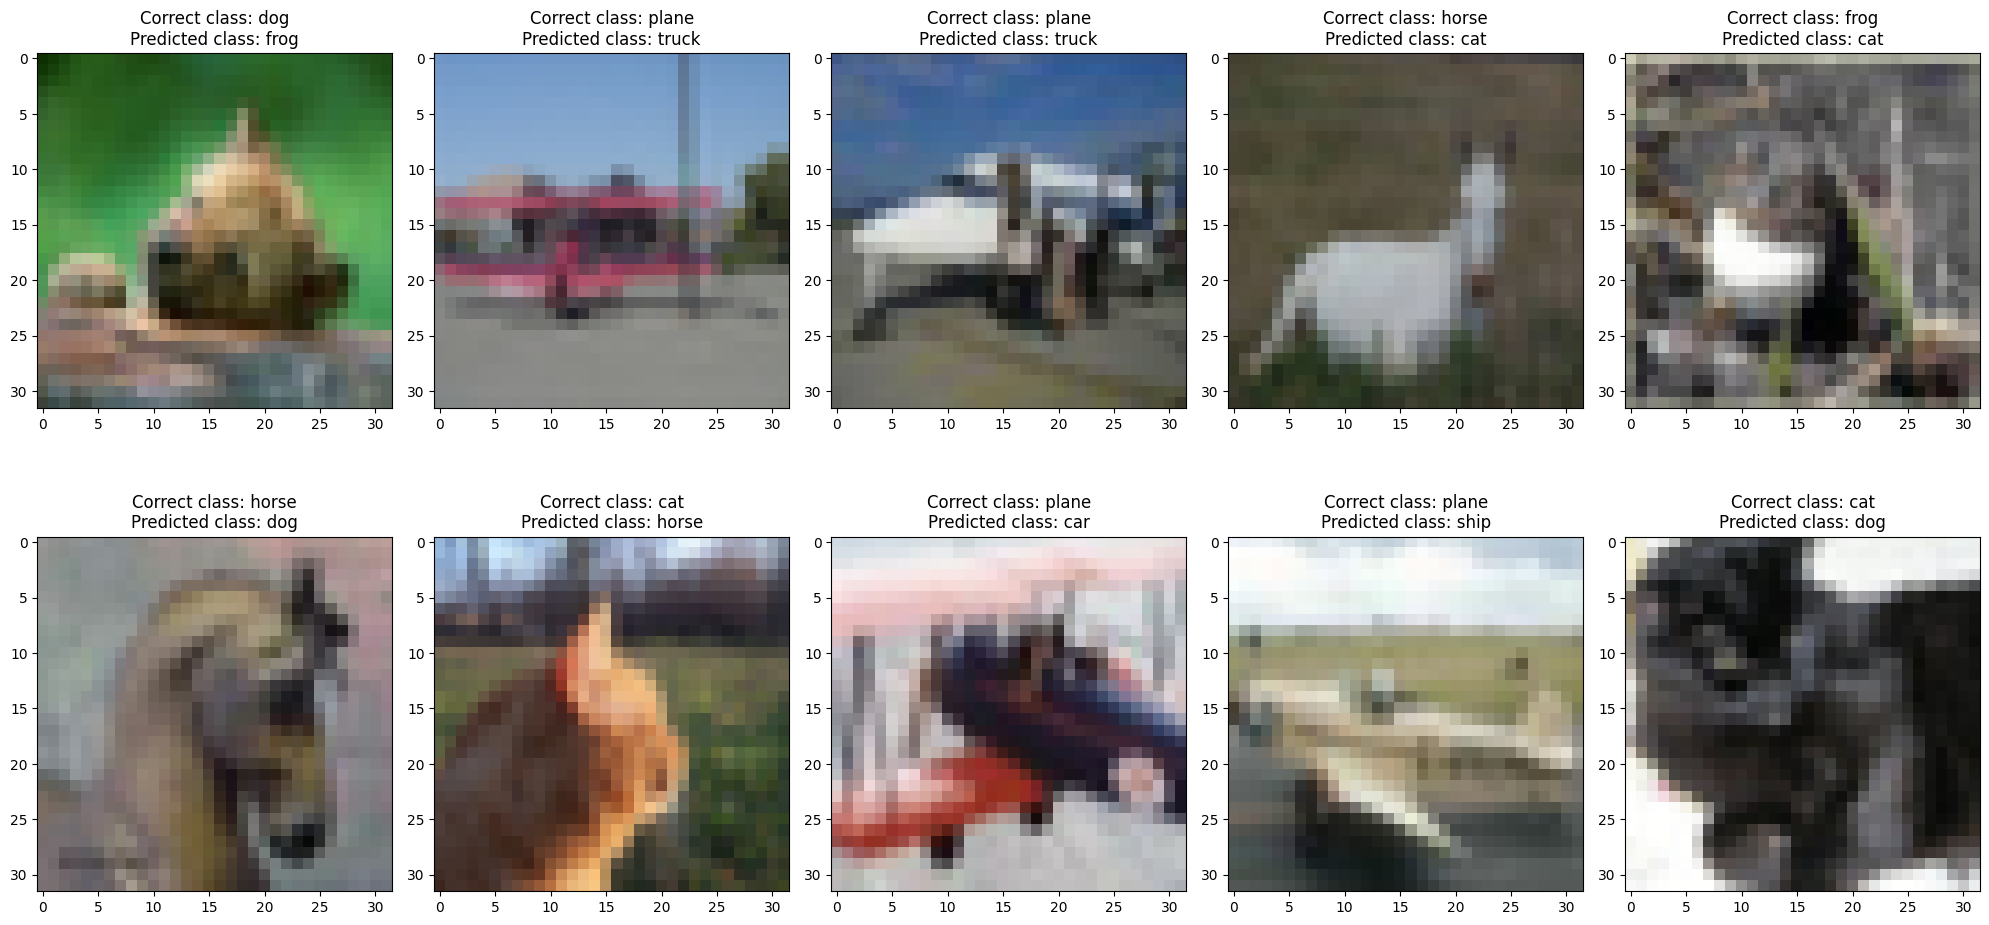

In [18]:
show_misclassified_images(
    misclassified_images[:10],
    predictions[:10],
    labels[:10],
    classes,
)

# Class - Accuracy

In [19]:
accuracy_classes(model, classes, test_loader)

Accuracy for class: plane is 94.3 %
Accuracy for class: car   is 97.8 %
Accuracy for class: bird  is 91.5 %
Accuracy for class: cat   is 84.1 %
Accuracy for class: deer  is 94.1 %
Accuracy for class: dog   is 88.7 %
Accuracy for class: frog  is 95.5 %
Accuracy for class: horse is 94.6 %
Accuracy for class: ship  is 95.7 %
Accuracy for class: truck is 94.7 %
